Num GPUs Available:  1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Restoring model weights from the end of the best epoch: 24.
Epoch 29: early stopping
Restoring model weights from the end of the best epoch: 19.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 26: early stopping
Restoring model weights from the end of the best epoch: 16.
Epoch 25: early stopping
Restoring model weights from the end of the best epoch: 15.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 6.
Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 6.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Restoring model weights from the end of the best epoch: 26.
Epoch 19: early stopping
Restoring model weights from the end of the best epoch: 9.
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test accuracy for single hidden layer model (Original): 0.89
F1-score for single hidden layer model (Original): 0.89
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test accuracy for two hidden layers model (Original): 0.89
F1-score for two hidden layers model (Original): 0.89
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Test accuracy for single hidden layer model (ADASYN): 0.85
F1-score for single hidden layer model (ADASYN): 0.86
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Test accuracy for two hidden layers model (ADASYN): 0.87
F1-score for two hidden layers model (ADASYN): 0.87
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test accuracy for single hidden layer model (ClusterBased): 0.77
F1-score for single hidden layer model (ClusterBased): 0.79
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Test accuracy for two hidden laye

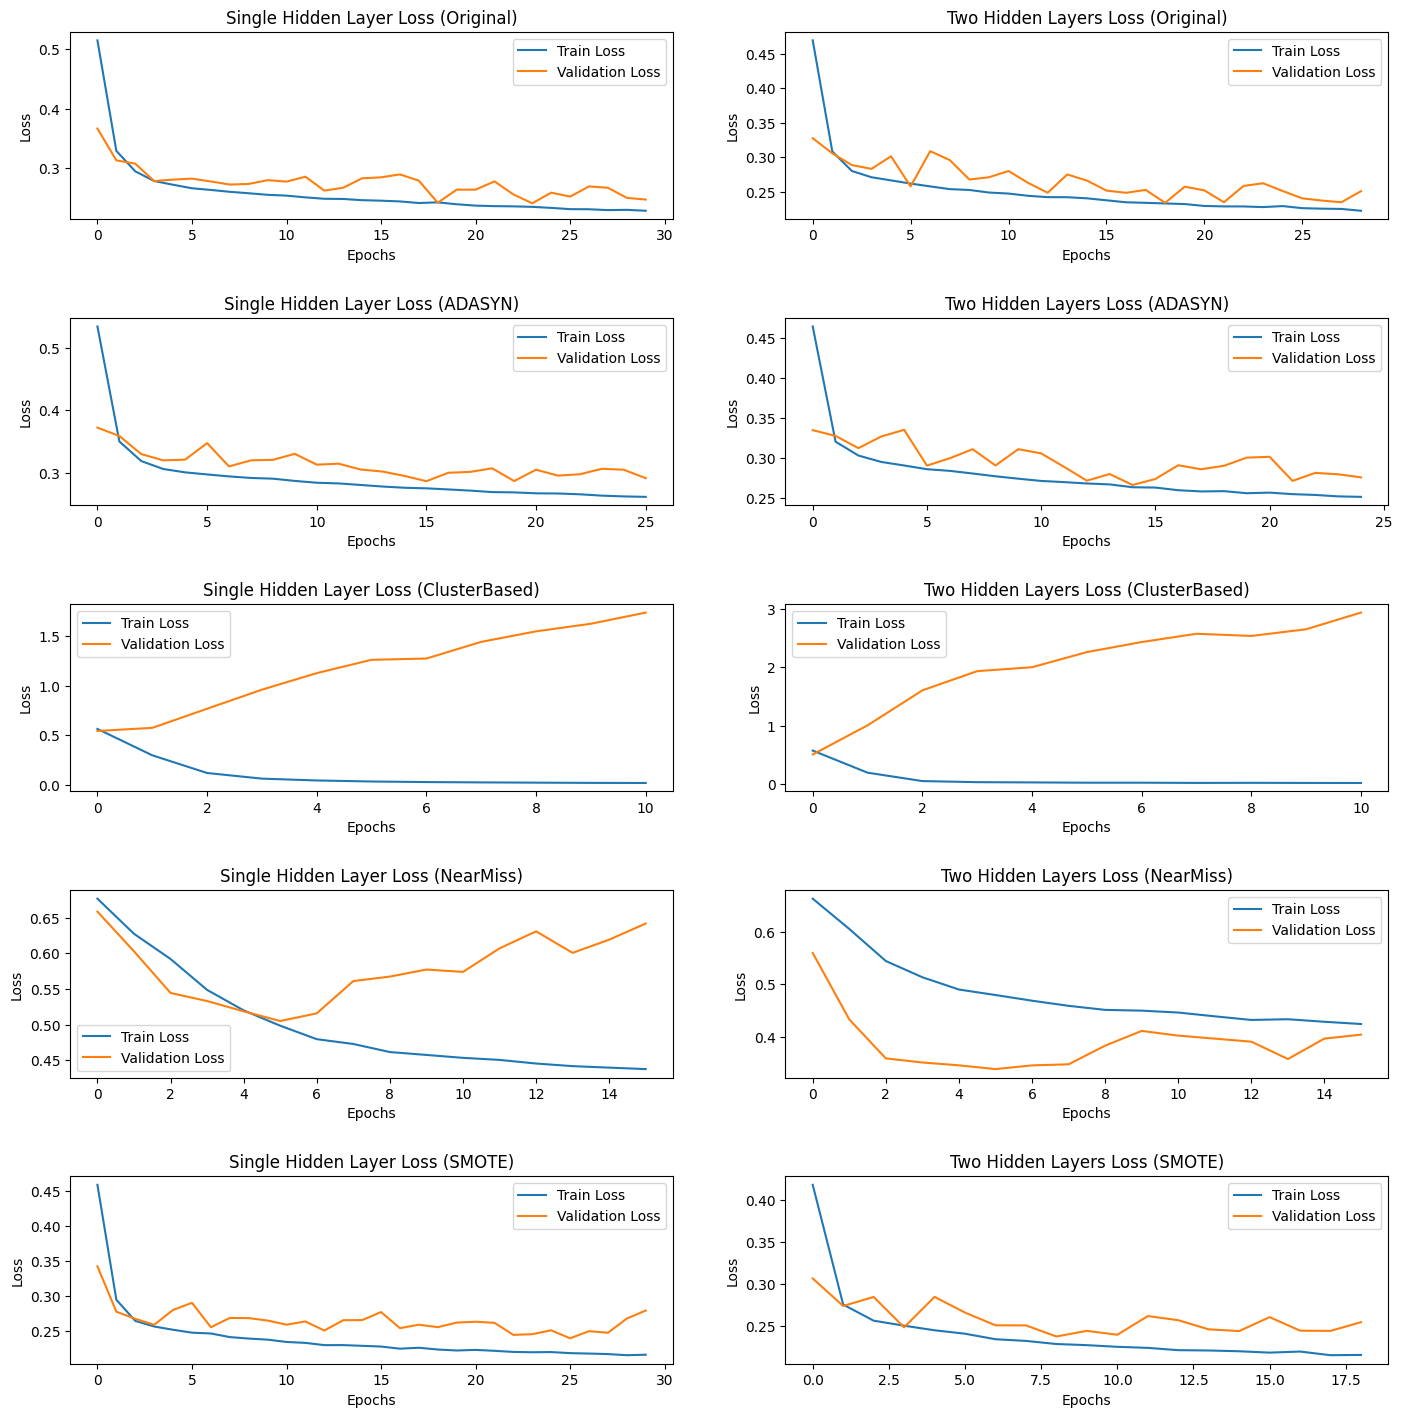

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter

# Check if any GPU is available to use
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Upload files (needed since trained the model using google collab)
#uploaded = files.upload()
# Load datasets and drop the 'ID' column
training_sets = {
    "Original": pd.read_csv('training_data_ID_numeric.csv').drop(columns=['ID']),
    "ADASYN": pd.read_csv('training_data_ID_numeric_adasyn.csv').drop(columns=['ID']),
    "ClusterBased": pd.read_csv('training_data_ID_numeric_clusterbased.csv').drop(columns=['ID']),
    "NearMiss": pd.read_csv('training_data_ID_numeric_nearmiss.csv').drop(columns=['ID']),
    "SMOTE": pd.read_csv('training_data_ID_numeric_smote.csv').drop(columns=['ID'])
}

validation_set = pd.read_csv('validation_data_ID_numeric.csv').drop(columns=['ID'])
test_set = pd.read_csv('test_data_ID_numeric.csv').drop(columns=['ID'])

# Separate features (X) and target (y) from validation and test sets
X_val = validation_set.drop(columns=['loan_status']).values
y_val = validation_set['loan_status'].values

X_test = test_set.drop(columns=['loan_status']).values
y_test = test_set['loan_status'].values

# Convert target (y) to categorical
num_classes = len(np.unique(y_val))
y_val = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

# Plot settings
fig, axes = plt.subplots(len(training_sets), 2, figsize=(15, 15))
fig.tight_layout(pad=5.0)

# Train a model for each training set (single and double hidden layer models)
checkpoint_filepath_single = 'best_model_single.keras'
checkpoint_filepath_double = 'best_model_double.keras'


#check class imbalance if there is any imbalance which exceeds the threshhold value in any of the training set return imbalance_ratio
def is_imbalanced(y):
    counter = Counter(y)
    ratios = [count / sum(counter.values()) for count in counter.values()]
    imbalance_ratio = max(ratios) / min(ratios)
    return imbalance_ratio > 1.5  # Threshold for imbalance


for i, (name, training_set) in enumerate(training_sets.items()):
    X_train = training_set.drop(columns=['loan_status']).values
    y_train = training_set['loan_status'].values

    # Handle class imbalance if encountered with any class imbalance
    if is_imbalanced(y_train):
        class_weights = compute_class_weight(
            class_weight='balanced',
            classes=np.unique(y_train.flatten()),
            y=y_train.flatten()
        )
        class_weights = dict(enumerate(class_weights))
    else:
        class_weights = None  # No weights if balanced


    # Convert training target to categorical
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)

    # Define early stopping callbacks
    #If there is no improvement on validation loss value for 15 epochs then stop the model training
    early_stopping_single = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )

    early_stopping_double = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )

    # Single hidden layer model
    single_layer_model = Sequential()
    single_layer_model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  #Input layer
    single_layer_model.add(Dense(32, activation='relu'))  # Single hidden layer
    single_layer_model.add(Dropout(0.5))
    single_layer_model.add(Dense(num_classes, activation='softmax')) #Output layer

    single_layer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                                loss='categorical_crossentropy',
                                metrics=['accuracy'])

    #Checkpoint for single hidden layered ANN model, store the parameters where program performs best according to validation loss
    checkpoint_callback_single = tf.keras.callbacks.ModelCheckpoint(
        filepath=f"best_model_single_{name}.keras",
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=0
    )

    single_history = single_layer_model.fit(X_train, y_train,
                                            epochs=30,
                                            batch_size=512,
                                            validation_data=(X_val, y_val),
                                            class_weight=class_weights,
                                            callbacks=[checkpoint_callback_single, early_stopping_single],
                                            verbose=0)  # Suppress output

    # Two hidden layer model
    double_layer_model = Sequential()
    double_layer_model.add(Dense(128, input_dim=X_train.shape[1], activation='relu')) #Input layer
    double_layer_model.add(Dense(64, activation='relu')) # Add first hidden layer
    double_layer_model.add(Dropout(0.5))
    double_layer_model.add(Dense(32, activation='relu'))  # Add second hidden layer
    double_layer_model.add(Dropout(0.5))
    double_layer_model.add(Dense(num_classes, activation='softmax')) #Output layer

    double_layer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                                loss='categorical_crossentropy',
                                metrics=['accuracy'])

    #Checkpoint for double hidden layered ANN model, store the parameters where program performs best according to validation loss
    checkpoint_callback_double = tf.keras.callbacks.ModelCheckpoint(
        filepath=f"best_model_double_{name}.keras",
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=0
    )

    double_history = double_layer_model.fit(X_train, y_train,
                                            epochs=30,
                                            batch_size=512,
                                            validation_data=(X_val, y_val),
                                            class_weight=class_weights,
                                            callbacks=[checkpoint_callback_double, early_stopping_double],
                                            verbose=0)  # Do not print out anything

    # Plot training and validation loss for single layer model
    axes[i, 0].plot(single_history.history['loss'], label='Train Loss')
    axes[i, 0].plot(single_history.history['val_loss'], label='Validation Loss')
    axes[i, 0].set_title(f'Single Hidden Layer Loss ({name})')
    axes[i, 0].set_xlabel('Epochs')
    axes[i, 0].set_ylabel('Loss')
    axes[i, 0].legend()

    # Plot training and validation loss for double layer model
    axes[i, 1].plot(double_history.history['loss'], label='Train Loss')
    axes[i, 1].plot(double_history.history['val_loss'], label='Validation Loss')
    axes[i, 1].set_title(f'Two Hidden Layers Loss ({name})')
    axes[i, 1].set_xlabel('Epochs')
    axes[i, 1].set_ylabel('Loss')
    axes[i, 1].legend()

# Evaluate models with the help of test data
for name, training_set in training_sets.items():
    X_train = training_set.drop(columns=['loan_status']).values
    y_train = training_set['loan_status'].values

    # Convert training target to categorical
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)

    # Reload best model for single layer
    single_layer_model.load_weights(f"best_model_single_{name}.keras")
    y_pred_single = single_layer_model.predict(X_test)
    y_pred_labels_single = np.argmax(y_pred_single, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)

    single_corrects = np.sum(y_pred_labels_single == y_test_labels)
    single_accuracy = single_corrects / len(y_test_labels)
    single_f1 = f1_score(y_test_labels, y_pred_labels_single, average='weighted')
    print(f"Test accuracy for single hidden layer model ({name}): {single_accuracy:.2f}")
    print(f"F1-score for single hidden layer model ({name}): {single_f1:.2f}")

    # Reload best model for double layer
    double_layer_model.load_weights(f"best_model_double_{name}.keras")
    y_pred_double = double_layer_model.predict(X_test)
    y_pred_labels_double = np.argmax(y_pred_double, axis=1)

    double_corrects = np.sum(y_pred_labels_double == y_test_labels)
    double_accuracy = double_corrects / len(y_test_labels)
    double_f1 = f1_score(y_test_labels, y_pred_labels_double, average='weighted')
    print(f"Test accuracy for two hidden layers model ({name}): {double_accuracy:.2f}")
    print(f"F1-score for two hidden layers model ({name}): {double_f1:.2f}")

plt.show()
